In [9]:
import torchvision
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm
import torch
import ImageData
import numpy as np
device = torch.device("cuda")
import time
import random

In [10]:
model_name = "resnet_weightedClasses"
model_image_size = 224
random.seed(42)

# vit = models.vit_l_16(models.ViT_L_16_Weights.IMAGENET1K_V1)

In [11]:
class ResNet(torch.nn.Module):
    def __init__(self, numClasses: int, softmax:bool = True):
        super(ResNet, self).__init__()

        self.resnet = torchvision.models.resnet152(weights='DEFAULT')
        for param in list(self.resnet.parameters())[:-1]:
            param.requires_grad = True

        self.resnet.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 216),
            torch.nn.ReLU(),
            torch.nn.Linear(216, 4)
        )
        
        
        # for param in self.inceptionBase.parameters():
        #     print(param.requires_grad)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        out = self.resnet(x)
        return out

In [12]:
model = ResNet(4).to(device)
# print(*list(model.children())[:-1])

In [13]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(torch.tensor([4.0, 1.0, 1.0, 1.0])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
import importlib
importlib.reload(ImageData)
trainDataLoader, validDataLoader, testDataLoader, unseenDataLoader = ImageData.getImagesDataloaders("./ArtiFact/", transforms = transform, batchSize=batch_size, onehot=True)

In [15]:
## adapted for a onehot encoding 
def evaluate_on_data(model, dataloader, dirty: bool = False):
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([4.0, 1.0, 1.0, 1.0])).to(device)
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_correct_dirty = 0.0

        num_samples = 0.0
        for data in tqdm(dataloader, desc="Eval: "):
            image, label = data
            label = label.to(device)
            image = image.to(device)
            outputs = model(image)
            loss = criterion(outputs, label)
            total_loss += loss.item()


            for i in range(len(label)):
                
                model_vote = 0
                answer = 0
                for j in range(len(outputs[i])):
                    if outputs[i][j] > outputs[i][model_vote]:
                        model_vote = j
                    if label[i][j] == 1:
                        answer = j
                
                if answer == model_vote:
                    num_correct += 1
                if answer == model_vote or (answer != 0 and model_vote in [1,2,3]):
                    num_correct_dirty += 1
                
                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples, num_correct_dirty / num_samples

In [16]:
num_epochs = 10
count = 0
valid_loss_array = np.zeros(num_epochs)
valid_acc_array = np.zeros(num_epochs)
valid_acc_dirty_array = np.zeros(num_epochs)

train_loss_array = np.zeros(num_epochs)
for epoch in range(num_epochs):
    batch_count = 0
    for data in tqdm(trainDataLoader, desc="Training: "):
        
        image, label = data
        
        label = label.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
          
        count += 1
        # print(loss)
            
        
    valid_loss, valid_acc, valid_acc_dirty = evaluate_on_data(model, validDataLoader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}, Dirty Valid ACC: {valid_acc_dirty}')
    valid_loss_array[epoch] = valid_loss
    train_loss_array[epoch] = loss.item()
    valid_acc_array[epoch] = valid_acc
    valid_acc_dirty_array[epoch] = valid_acc_dirty


Eval: 100%|██████████| 6180/6180 [09:14<00:00, 11.15it/s]


Epoch [1/10], Training Loss: 0.5746, Valid Loss: 0.5378135424193495, Valid ACC: 0.8560563152358605, Dirty Valid ACC: 0.8756675297354155


Eval: 100%|██████████| 6180/6180 [07:12<00:00, 14.28it/s]


Epoch [2/10], Training Loss: 0.3396, Valid Loss: 0.46397906482791307, Valid ACC: 0.8799963589287159, Dirty Valid ACC: 0.8972611052674164


Eval: 100%|██████████| 6180/6180 [07:17<00:00, 14.12it/s]


Epoch [3/10], Training Loss: 0.7710, Valid Loss: 0.40606011566793454, Valid ACC: 0.8811797070960433, Dirty Valid ACC: 0.8957136499716806


Eval: 100%|██████████| 6180/6180 [07:04<00:00, 14.54it/s]


Epoch [4/10], Training Loss: 1.4084, Valid Loss: 0.40841500854996166, Valid ACC: 0.8963508374463953, Dirty Valid ACC: 0.9111072902338377


Eval: 100%|██████████| 6180/6180 [07:02<00:00, 14.63it/s]


Epoch [5/10], Training Loss: 0.1329, Valid Loss: 0.36427392998655944, Valid ACC: 0.907243709037948, Dirty Valid ACC: 0.9221013026943927


Eval: 100%|██████████| 6180/6180 [07:01<00:00, 14.66it/s]


Epoch [6/10], Training Loss: 0.1669, Valid Loss: 0.3632924179183618, Valid ACC: 0.8978274941338296, Dirty Valid ACC: 0.9120580144024597


Eval: 100%|██████████| 6180/6180 [06:42<00:00, 15.35it/s]


Epoch [7/10], Training Loss: 1.2602, Valid Loss: 0.3580409688441128, Valid ACC: 0.9076786147746582, Dirty Valid ACC: 0.9221114167812929


Eval: 100%|██████████| 6180/6180 [06:39<00:00, 15.46it/s]


Epoch [8/10], Training Loss: 1.9292, Valid Loss: 0.33576203216674616, Valid ACC: 0.9117748199692531, Dirty Valid ACC: 0.9256816894570759


Eval: 100%|██████████| 6180/6180 [06:49<00:00, 15.09it/s]


Epoch [9/10], Training Loss: 0.2539, Valid Loss: 0.3291414564649942, Valid ACC: 0.9127963427461768, Dirty Valid ACC: 0.926248078323489


Eval: 100%|██████████| 6180/6180 [06:46<00:00, 15.19it/s]

Epoch [10/10], Training Loss: 1.0784, Valid Loss: 0.33286718530216436, Valid ACC: 0.9219192491301885, Dirty Valid ACC: 0.9363014807023222


In [17]:
with open(model_name + '_valid_loss.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    
with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)

with open(model_name + '_valid_dirty_acc.npy', 'wb') as f:
    np.save(f, valid_acc_dirty_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

In [18]:
import matplotlib.pyplot as plt

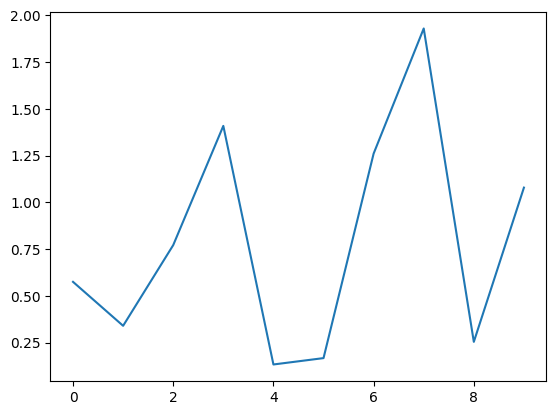

In [19]:
plt.plot(train_loss_array)

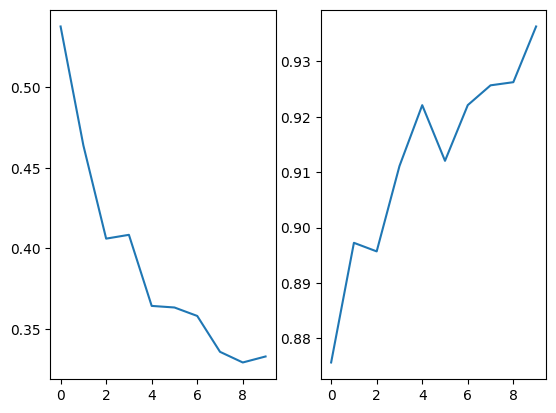

In [20]:
figure, axis = plt.subplots(1,2)
axis[0].plot(valid_loss_array)
axis[1].plot(valid_acc_dirty_array)

In [21]:
test_loss, test_acc, test_acc_dirty = evaluate_on_data(model, testDataLoader, dirty=True)
print(f'Test Loss: {test_loss}, Test ACC: {test_acc}, Dirty Test ACC: {test_acc_dirty}')

Eval: 100%|██████████| 32465/32465 [47:51<00:00, 11.30it/s]

Test Loss: 0.39961913764545054, Test ACC: 0.8992547585906833, Dirty Test ACC: 0.9292126546650264


In [22]:
torch.save(model.state_dict(), "WeightedResnet.pth")

In [23]:
unseen_loss, unseen_acc, unseen_acc_dirty = evaluate_on_data(model, unseenDataLoader, dirty=True)
print(f'Unseen Loss: {unseen_loss}, Unseen ACC: {unseen_acc}, Dirty Unseen ACC: {unseen_acc_dirty}')

Eval: 100%|██████████| 1569/1569 [01:00<00:00, 25.88it/s]

Unseen Loss: 1.950462072483505, Unseen ACC: 0.458638826904686, Dirty Unseen ACC: 0.6229678036340452
